# Mathematical Morphology for Color Image Processing

There are two procedures to be implemented: 

<ol>
    <li> RGB opening </li>
    <li> Composition of operations in RGB channels: gradient, opening, closing </li>
    <li> procedure 1 followed by procedure 2 </li>
</ol>
    
The input must be in this order:

> image filename
> k (size of the structuring element) <br>
> option = 1 for RGB opening, 2 = for composition of operations <br>
> For all options you must use the disk structuring element from scikit-image's morphology package

Below the details for each option

## 1 RGB opening
Implement a function that gets as input an RGB image and the size of the structuring element (as implemented in scikit-image). Perform opening on each RGB channel separately.

## 2 Composition of operations in RGB channels: gradient, opening, closing
<ul>
    <li> convert the input image to HSV </li>
    <li> get the H channel and normalize it to the interval 0 - 255 </li>
    <li> with the structuring element disk, perform the morphological gradient </li>
    <li> normalize the resulting morphological gradient to the interval 0 - 255 </li>
    <li> compose a new RGB image having the normalized gradient in the R channel </li>
    <li> the opening of the normalized H (obtained in step 2) in G channel </li>
    <li> the closing of the normalized H (obtained in step 2) in B channel </li>
</ul>

## 3 Using the two above procedures

<ul>
    <li> Perform the RGB opening using the size of the structuring element = 2*k </li>
    <li> Use the opened image as input to the composition method using the size of the structuring element = k </li>
</ul>

In all cases, compute the RMSE comparing the input image and the image after processing and show it with 4 decimal places 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import morphology
import imageio
import math

In [2]:
def normalization(I):
    """Function to perform image normalization (0-255)"""
    I_norm = ((I - np.amin(I)) * 255.0) / (np.amax(I) - np.amin(I))

    return I_norm

def RMSE(output_img, input_img): # Root Square Error
    """Function to compute Root Square Error between input and output images"""
    I,J,K = input_img.shape # image dimensions
    sumerror = 0

    for i in range(I):
        for j in range(J):
            for k in range(K):
                # sum of square errors
                sumerror = sumerror + math.pow(float(output_img[i][j][k]) - float(input_img[i][j][k]), 2)

    RMSE = math.sqrt(sumerror / (I*J)) # sum root (final result)
    print('{:.4f}'.format(RMSE)) # print error with 4 decimal places
      

# (+) => Dilating
# (-) => Erosing

def gradient(img, k):
    """Function to compute the morphological gradient 
     
       Parameters:
       img -> grayscale image
       k   -> size of the structuring element
    """
    img_dilation = morphology.dilation(img, morphology.disk(k)).astype(np.uint8)
    img_erosion = morphology.erosion(img, morphology.disk(k)).astype(np.uint8)
    
    img_grad = img_dilation - img_erosion
    
    return img_grad

def opening(img, k):
    """Function to compute the opening 
     
       Parameters:
       img -> grayscale image
       k   -> size of the structuring element
    """
    # opening: (A (-) B) (+) B
    
    #Erosion
    img_erosion = morphology.erosion(img, morphology.disk(k)).astype(np.uint8)
    #Dilation
    img_opn = morphology.dilation(img_erosion, morphology.disk(k)).astype(np.uint8)

    return img_opn

def closing(img, k):
    """Function to compute the closing 
     
       Parameters:
       img -> grayscale image
       k   -> size of the structuring element
    """
    # closing: (A (+) B) (-) B
    
    #Dilation
    img_dilation = morphology.dilation(img, morphology.disk(k)).astype(np.uint8)
    #Erosion
    img_cls = morphology.erosion(img_dilation, morphology.disk(k)).astype(np.uint8)
    
    return img_cls
    
def rgb_opening(img, k):
    """Function to compute the opening of a rgb image
     
       Parameters:
       img -> rgb image
       k   -> size of the structuring element
    """
    R_opn = opening(img[:,:,0], k)
    G_opn = opening(img[:,:,1], k)                                                             
    B_opn = opening(img[:,:,2], k)
    
    img_opn =  np.array(img, copy=True).astype(np.uint32)
    img_opn[:,:,0] = np.clip(R_opn, 0, 255)
    img_opn[:,:,1] = np.clip(G_opn, 0, 255)
    img_opn[:,:,2] = np.clip(B_opn, 0, 255)
    
    return img_opn

def composition_of_operations(img, k):
    """Function to compute the following operation:
        (1) convert a rgb image to hsv
        (2) normalize H, compute de H gradient and normalize it again
        (3) new RGB image with: 
            (3.1) R <= morphological gradient of H
            (3.2) G <= opening of the normalized H
            (3.3) B <= opening of the normalized H
        
       Parameters:
       img -> rgb image
       k   -> size of the structuring element
    """
    img_hsv = mpl.colors.rgb_to_hsv(img)
    H_norm = normalization(img_hsv[:,:,0])
    H_grad = gradient(H_norm, k)
    H_grad_norm = normalization(H_grad)
    
    img_comp =  np.array(img, copy=True).astype(np.uint32)
    img_comp[:,:,0] = np.clip(H_grad_norm, 0, 255)
    img_comp[:,:,1] = np.clip(opening(H_norm,k), 0, 255)
    img_comp[:,:,2] = np.clip(closing(H_norm,k), 0, 255)
    
    return img_comp

def opening_composition(img, k):
    """Function to compute perform an rbg opening followed by a composition of operations
        
       Parameters:
       img -> rgb image
       k   -> size of the structuring element
    """
    img_opn = rgb_opening(img, 2*k)
    img_out = composition_of_operations(img_opn, k)
    
    return img_out

In [3]:
filename = "pencil.png"
input_img = imageio.imread(filename)
k = int(input())
op = int(input())

2
2


In [4]:
if op == 1:
    out_img = rgb_opening(input_img, k)
elif op == 2:
    out_img = composition_of_operations(input_img, k)
elif op == 3:
    out_img = opening_composition(input_img, k)

In [5]:
RMSE(out_img, input_img)

189.2096


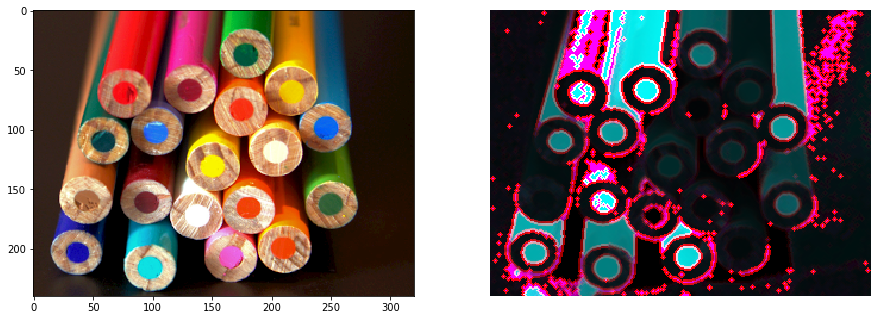

In [6]:
plt.figure(figsize=(15,15)) 
plt.subplot(121)
plt.imshow(input_img, cmap="gray", vmin=0, vmax=255)
plt.title("")
plt.subplot(122)
plt.imshow(out_img)
plt.title("")
plt.axis('off')
plt.show()